In [1]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
# make deterministic
seed = 42
from mingpt.utils import set_seed
set_seed(seed)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import random
import os

In [4]:
# config
numEpochs = 50 # number of epochs to train the GPT+PT model
embeddingSize = 512 # the hidden dimension of the representation of both GPT and PT
numPoints=20 # number of points that we are going to receive to make a prediction about f given x and y, if you don't know then use the maximum
numVars=2 # the dimenstion of input points x, if you don't know then use the maximum
numYs=1 # the dimension of output points y = f(x), if you don't know then use the maximum
blockSize = 100 # spatial extent of the model for its context
batchSize = 128 # batch size of training data
dataDir = 'D:/Datasets/Symbolic Dataset/Datasets/MyDataGenerator'
dataInfo = 'XYE_{}Var_{}Points_{}EmbeddingSize'.format(numVars, numPoints, embeddingSize)
target = 'Skeleton' #'Skeleton' #'EQ'
dataFolder = "nv2_np[20, 21]_trR[-1.0, 4.0]_teR[4.1, 3.0]_templateBased_NGUYEN"
addr = './SavedModels/bestModel/' # where to save model
maxNumFiles = 30
bestLoss = None # if there is any model to load as pre-trained one

In [5]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size, chars, target='EQ'):
        data_size, vocab_size = len(data), len(chars)
        print('data has %d examples, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        
        # padding token
        self.paddingToken = '_'
        self.paddingID = self.stoi[self.paddingToken]
        self.stoi[self.paddingToken] = self.paddingID
        self.itos[self.paddingID] = self.paddingToken
        self.threshold = [-1,1]
        
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data # it should be a list of examples
        self.target = target
    
    def __len__(self):
        return len(self.data)-1

    def __getitem__(self, idx):
        # grab an example from the data
        chunk = self.data[idx] # sequence of tokens including x, y, eq, etc.
        
        try:
            chunk = json.loads(chunk) # convert the sequence tokens to a dictionary
        except:
            print("Couldn't convert to json: {}".format(chunk))
            
        # encode every character in the equation to an integer
        # < is SOS, > is EOS
        dix = [self.stoi[s] for s in '<'+chunk[self.target]+'>']
        inputs = dix[:-1]
        outputs = dix[1:]
        
        # add the padding to the equations
        paddingSize = max(self.block_size-len(inputs),0)
        paddingList = [self.paddingID]*paddingSize
        inputs += paddingList
        outputs += paddingList 
        
        # make sure it is not more than what should be
        inputs = inputs[:self.block_size]
        outputs = outputs[:self.block_size]
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(zip(chunk['X'], chunk['Y'])):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1]) == float or type(xy[1]) == int else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=self.threshold[1], 
                                 neginf=self.threshold[0])
            p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
            p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
            points[:,idx] = p
        
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        inputs = torch.tensor(inputs, dtype=torch.long)
        outputs = torch.tensor(outputs, dtype=torch.long)
        return inputs, outputs, points


In [6]:
import json
from tqdm import tqdm
import glob
def processDataFiles(path, files):
    text = ''""
    for f in tqdm(files):
        with open(path+f, 'r') as h: 
            lines = h.read() # don't worry we won't run out of file handles
            if lines[-1]==-1:
                lines = lines[:-1]
            text += lines #json.loads(line)       
            
    return text

In [7]:
path = '{}/{}/Train/'.format(dataDir, dataFolder)
files = os.listdir(path)[:maxNumFiles]
text = processDataFiles(path, files)
chars = sorted(list(set(text))+['_','T','<','>']) # extract unique characters from the text before converting the text to a list
# T is for the test data
text = text.split('\n') # convert the raw text to a set of examples
text = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(text) # shuffle the dataset, it's important for combined number of variables
train_dataset = CharDataset(text, blockSize, chars, target=target) 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


data has 97065 examples, 50 unique.


In [8]:
idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points = train_dataset.__getitem__(idx)
print('inputs:{}'.format(inputs))
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))
minimum, maximum = points.min(), points.max()
print(minimum, maximum)

inputs:tensor([22, 24,  5, 47, 12,  5,  5, 14,  6, 24,  5, 47, 12,  5,  5, 13,  6, 24,
         5, 47, 12,  6, 24, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34])
id:15795
inputs:<C*x1**3+C*x1**2+C*x1+C_____________________________________________________________________________
outputs:C*x1**3+C*x1**2+C*x1+C>_____________________________________________________________________________
points:tensor([[ 1.0000,  0.5700, -0.7500,  1.0000,  1.0000,  1.0000,  1.0000,  0.6300,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -0.0800,  1.0000,
          1.0000,  1.0000,  0.9700,  1.0000],
        [ 1.0000,  1.0000,  1.0000, -0.6700,  1.0000,  1.0000,  1.0000,  1.0000,
          0.3500,  1.0

In [9]:
path = '{}/{}/Val/'.format(dataDir,dataFolder)
files = os.listdir(path)[:maxNumFiles]
textVal = processDataFiles(path, files)
textVal = textVal.split('\n') # convert the raw text to a set of examples
val_dataset = CharDataset(textVal, blockSize, chars, target=target)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.12it/s]

data has 964 examples, 50 unique.


In [10]:
idx = np.random.randint(val_dataset.__len__())
inputs, outputs, points = val_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(-1.) tensor(1.)
id:860
inputs:<C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C________________________________________________________________
outputs:C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C>________________________________________________________________
points:tensor([[ 1.0000,  1.0000, -0.5900,  1.0000,  0.0900,  1.0000,  1.0000,  1.0000,
         -0.2500,  1.0000,  1.0000, -0.3900,  0.5900,  0.3300,  1.0000,  1.0000,
         -0.6100, -0.7600,  0.1500,  1.0000],
        [ 1.0000,  0.1000,  0.7000,  0.8100,  1.0000,  0.3000,  1.0000,  1.0000,
          1.0000,  1.0000, -0.3900, -0.9800,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000, -0.2200,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -1.0000,
          1.0000,  0.7400,  1.0000,  1.0000]])


In [11]:
path = '{}/{}/Test/'.format(dataDir,dataFolder)
files = os.listdir(path)[:maxNumFiles]
textTest = processDataFiles(path, files)
textTest = textTest.split('\n') # convert the raw text to a set of examples
# test_dataset_target = CharDataset(textTest, blockSize, chars, target=target)
test_dataset = CharDataset(textTest, blockSize, chars)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]

data has 972 examples, 50 unique.


In [12]:
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(-0.6000) tensor(1.)
id:270
inputs:<1.84*sqrt(2.09*x1+1.71)+2.0________________________________________________________________________
outputs:1.84*sqrt(2.09*x1+1.71)+2.0>________________________________________________________________________
points:tensor([[ 1.0000,  0.2800,  0.0800,  1.0000,  1.0000,  1.0000,  1.0000,  0.1500,
         -0.6000, -0.0900,  1.0000,  1.0000, -0.5400,  1.0000, -0.1500,  0.5100,
          1.0000,  0.2300, -0.5600,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.3800, -0.2000,  1.0000,
         -0.5500,  1.0000,  1.0000,  1.0000, -0.1800, -0.0900, -0.2100,  1.0000,
          0.0900,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000]])


In [13]:
from mingpt.model import GPT, GPTConfig, PointNetConfig
pconf = PointNetConfig(embeddingSize=embeddingSize, 
                       numberofPoints=numPoints, 
                       numberofVars=numVars, 
                       numberofYs=numYs)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=embeddingSize, padding_idx=train_dataset.paddingID)
model = GPT(mconf, pconf)

05/27/2021 13:37:45 - INFO - mingpt.model -   number of parameters: 3.058228e+07


In [14]:
fName = '{}_SymbolicGPT_{}_{}_{}_MINIMIZE.txt'.format(dataInfo, 
                                             'GPT_PT_Summation', 
                                             'Padding',
                                             blockSize)

In [15]:
ckptPath = '{}/{}.pt'.format(addr,fName.split('.txt')[0])
print(ckptPath)
if bestLoss != None:
    # load the best model
    print('Model has been loaded!')
    model.load_state_dict(torch.load(ckptPath))

./SavedModels/bestModel//XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt


In [16]:
from mingpt.trainer import Trainer, TrainerConfig
import os

try: 
    os.mkdir(addr)
except:
    print('Folder already exists!')
    
# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=numEpochs, batch_size=batchSize, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*blockSize,
                      num_workers=0, ckpt_path=ckptPath)
trainer = Trainer(model, train_dataset, val_dataset, tconf, bestLoss)

try:
    trainer.train()
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Folder already exists!


epoch 1 iter 758: train loss 0.05106. lr 3.002487e-04: 100%|█████████████████████████| 759/759 [05:47<00:00,  2.19it/s]
05/27/2021 13:43:35 - INFO - mingpt.trainer -   test loss: 0.223814
05/27/2021 13:43:35 - INFO - mingpt.trainer -   saving ./SavedModels/bestModel//XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt
epoch 2 iter 5: train loss 0.06104. lr 2.965182e-04:   1%|▏                            | 6/759 [00:03<06:47,  1.85it/s]

KeyboardInterrupt


In [17]:
# load the best model
model.load_state_dict(torch.load(ckptPath))
model = model.eval().to(trainer.device)

In [18]:
# add a safe wrapper for numpy math functions
from numpy import *
import numpy as np

def divide(x, y):
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)
  return np.divide(x,y+1e-5)

def sqrt(x):
  x = np.nan_to_num(x)
  return np.sqrt(np.abs(x)) 

# Mean square error
def mse(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        our_sum += (y_hat[i] - y_gold[i]) ** 2

    return our_sum / len(y_gold)

# Mean square error
def relativeErr(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        if y_gold[i] < 1: 
            # use regular MSE
            our_sum += (y_hat[i] - y_gold[i]) ** 2
        else:
            # use relative MSE
            our_sum += ((y_hat[i] - y_gold[i])/y_gold[i]) ** 2

    return our_sum / len(y_gold)

In [19]:
# class pointsDataset(Dataset):

#     def __init__(self, data):
#         # data should be a list of x,y pairs
#         self.x = data[0] # it should be a list
#         self.y = data[1] # it should be a list
#         self.threshold = [-1000,1000]
    
#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         # grab an example from the data
#         x = self.x[idx] 
#         y = self.y[idx] 
        
#         p = x+[y]
        
#         p = torch.tensor(p, dtype=torch.float)
#         p = torch.nan_to_num(p, nan=0.0, 
#                              posinf=self.threshold[1], 
#                              neginf=self.threshold[0])
#         p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
#         p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
        
#         return p
    
# # train a mlp to find the constants
# data = pointsDataset((t['X'],t['Y']))
# loader = torch.utils.data.DataLoader(
#                                 data, 
#                                 shuffle=False, 
#                                 pin_memory=True,
#                                 batch_size=batchSize,
#                                 num_workers=0)
# class MLP(nn.Module):
#     def __init__(self, inputSize, outputSize):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(inputSize, 100),
#             nn.ReLU(),
#             nn.Linear(100, outputSize)
#         )

#     def forward(self, x):
#         c = self.layers(x)
#         return c
    
#     def loss(self, constants, eq, X, Y):
#         # constants is the output of the model
#         err = torch.zeros(len(constants)) # batch_size
        
#         # sample number of points
#         indexes = []
#         numberSamples = 10
#         while len(indexes) != numberSamples:
#             randNum = np.random.randint(len(batch))
#             indexes.append(randNum)
#         X = X[indexes,:]
#         Y = Y[indexes,:]
        
#         # replace the constants with their predicted values
#         for idx, const in enumerate(constants):
#             eq = eq.replace('C','{}').format(*const.tolist())
        
#         # calculate the error for a limited number of points, approximate the error
#         for x,y in zip(X,Y):
#             # replace variables with their values
#             for i,e in enumerate(x):
#                 eqTemp = eq.replace('x{}'.format(i+1), str(e.item()))
                
#             # calculate the error
#             yHat = eval(eqTemp)
#             err[idx] += (y.item()-yHat)**2
#         err[idx] /= numberSamples
            
#         print(err.shape, constants.shape)
#         return err
    
# c = [0 for i,x in enumerate(predicted) if x=='C']
# network = MLP(numVars+numYs, len(c))
# cHat = network(batch)
# err = network.loss(cHat, predicted, batch[:,:numVars], batch[:,-numYs:])

In [20]:
# alright, let's sample some character-level symbolic GPT
from mingpt.utils import sample
from gp_model import Genetic_Model
from mlp_model import MLP_Model
from scipy.optimize import least_squares, newton, minimize

    
loader = torch.utils.data.DataLoader(
                                test_dataset, 
                                shuffle=False, 
                                pin_memory=True,
                                batch_size=1,
                                num_workers=0)

testRange = [3.1,6.0]
numTestPoints = 10
#test = np.linspace(3.1,6.0,numTestPoints)

gpm = Genetic_Model(n_jobs=-1)
mlp = MLP_Model()

resultDict = {}
try:
    with open(fName, 'w', encoding="utf-8") as o:
        modelName = 'SymbolicGPT'
        resultDict[fName] = {modelName:[],
                             'GP':[],
                             'MLP':[]}

        for i, batch in enumerate(loader):
                
            inputs,outputs,points = batch

            print('Test Case {}.'.format(i))
            o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

            t = json.loads(textTest[i])

            inputs = inputs[:,0:1].to(trainer.device)
            points = points.to(trainer.device)
            outputsHat = sample(model, inputs, blockSize, points=points,
                          temperature=1.0, sample=True, 
                          top_k=40)[0]

            # filter out predicted
            target = ''.join([train_dataset.itos[int(i)] for i in outputs[0]])
            predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])

            target = target.strip(train_dataset.paddingToken).split('>')
            target = target[0] if len(target[0])>=1 else target[1]
            target = target.strip('<').strip(">")
            predicted = predicted.strip(train_dataset.paddingToken).split('>')
            predicted = predicted[0] if len(predicted[0])>=1 else predicted[1]
            predicted = predicted.strip('<').strip(">")
            
            print('Target:{}\nSkeleton:{}'.format(target, predicted))
            
            o.write('{}\n'.format(target))
            o.write('{}:\n'.format(modelName))
            o.write('{}\n'.format(predicted))

            # train a regressor to find the constants (too slow)
            c = [1 for i,x in enumerate(predicted) if x=='C']            
            def lossFunc(constants, eq, X, Y):
                err = 0
                eq = eq.replace('C','{}').format(*constants)

                for x,y in zip(X,Y):
                    eqTemp = eq + ''
                    for i,e in enumerate(x):
                        eqTemp = eqTemp.replace('x{}'.format(i+1), str(e))
                    try:
                        yHat = eval(eqTemp)
                    except:
                        yHat = 100
                    err += (y-yHat)**2
                err /= len(Y)
                return err
            
            try:
                if len(c) == 0:
                    pass # do nothing
                else:
#                     cHat = least_squares(lossFunc, c, ftol=1e-3,
#                                          args=(predicted, t['X'], t['Y']))
                    
                    # for easier comparison, we are using minimize package  
                    cHat = minimize(lossFunc, c,
                                   args=(predicted, t['X'], t['Y'])) 
            
#                     cHat= newton(lossFunc, c, maxiter=100,
#                                  args=(predicted, t['X'], t['Y']))
                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except:
                print('Wrong Equation:{}'.format(predicted))
                raise
                predicted = 0

            # TODO: let's enjoy GPU

            print('Skeleton+LS:{}'.format(predicted))

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = target + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    YEval = eval(eqTmp)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 1000 if np.isinf(Yhat) else Yhat
                except:
                    Yhat = 1000
                Yhats.append(Yhat)
            err = relativeErr(Ys,Yhats)

            if type(err) is np.complex128 or np.complex:
                err = abs(err.real)

            resultDict[fName][modelName].append(err)

            o.write('{}\n{}\n\n'.format( 
                                    predicted,
                                    err
                                    ))

            print('Err:{}'.format(err))
            
            # Calculate error for baselines

    #         # tokenize to get input x, input y, and true eqn
    #         train_data_x = t["X"]
    #         train_data_y = t["Y"]
    #         test_data_x = t["XT"]
    #         test_data_y = t["YT"]

    #         # train MLP model
    #         mlp.reset()
    #         model_eqn, _, best_err = mlp.repeat_train(
    #                                                 train_data_x, 
    #                                                 train_data_y,
    #                                                 test_x=test_data_x, 
    #                                                 test_y=test_data_y,                                     
    #                                                 verbose=False)
    #         test_y_hat = mlp.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("{}: {}".format(mlp.name, model_eqn)[:550])
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['MLP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('MLP', 
    #                                    err,
    #                                    model_eqn))

    #         # train GP model
    #         gpm.reset()
    #         model_eqn, _, best_err = gpm.repeat_train(train_data_x, train_data_y,
    #                                                 test_x=test_data_x, test_y=test_data_y,
    #                                                 verbose=False)
    #         print("{}: {}".format(gpm.name, model_eqn)[:550])
    #         test_y_hat = gpm.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['GP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('GP', 
    #                                    err,
    #                                    model_eqn))
            print('') # just an empty line
    print('Avg Err:{}'.format(np.mean(resultDict[fName][modelName])))
    
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Test Case 0.
Target:1.14*sqrt(1.16*x1+1.51)+1.02
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:0.5749924275531042*sin(1.275264793793841*x1**2)*cos(1.062896896357819*x1+0.6919994672305634)+2.9027092601793356
Err:0.044925178376112485

Test Case 1.
Target:1.5*log(1.55*x1+1.43)+1.17*log(1.4*x1**2+1.18)+1.37
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:866.1159058296058*sin(1.635761046126954*x1**2)*cos(0.0037621115898104863*x1+1.56482309144145)+4.315800359394713
Err:0.44832591651703

Test Case 2.
Target:1.62*x1**3+1.22*x1**2+1.35*x1+1.41
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:31.91648410294544*sin(0.9023091772916709*x1**2)*cos(-2.415058045267611*x1+11.766587277450883)+33.541105744331865
Err:0.3236721886218222

Test Case 3.
Target:1.22*sin(1.42*x1+2.02)+1.84*sin(1.85*x1**2+1.66*x1)+1.87
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2.354121602709187*sin(0.40566950413160296*x1**2)*cos(1.4351748389200654*x1+0.3740013184432023)+2.314118375887288
Err:0.6260731354931053

T

Target:2.06*x1**x2+1.05
Skeleton:C*sin(C*x1+C)+C*sin(C*x2**2+C)+C
Skeleton+LS:1100.8442299324333*sin(-0.09878278809539327*x1+-1.4759427412764596)+31.643238477434924*sin(2.8633274417788495*x2**2+-7.427516009909296)+1110.6611195146593
Err:0.5372522430319042

Test Case 33.
Target:1.59*log(1.49*x1+2.07)+1.48*log(1.67*x1**2+2.1)+1.12
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2.45074793404184*sin(-0.9432172682985572*x1**2)*cos(2.8190070782743173*x1+4.202574249756464)+6.101256941912152
Err:0.07440294808794416

Test Case 34.
Target:1.28*x1**5+1.53*x1**4+1.08*x1**3+1.59*x1**2+1.17*x1+1.19
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:-527.9967035194355*sin(16.84002371195681*x1+-21.344780531947666)*cos(-149.3694647408719*x2+-21.561576323587502)+236.35395076005932
Err:0.6582280807405302

Test Case 35.
Target:1.78*x1**4+1.79*x1**3+1.36*x1**2+1.17*x1+1.81
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:-233.84657522827573*sin(-3.1805924043672116*x1**2)*cos(7.804766652860788*x1+-2.14523

Target:1.85*log(1.78*x1+1.86)+1.99*log(1.7*x1**2+1.67)+1.91
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:527.523816481255*sin(0.04277514106485861*x1+4.522645426288959)*cos(-0.014873226213724606*x2+3.163907650963862)+-515.1038861329447
Err:0.0009219974392695431

Test Case 65.
Target:1.41*x1**4+1.99*x1**3+2.1*x1**2+1.77*x1+1.31
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:-225.7054164393189*sin(3.842183383269424*x1+-0.34825800574884735)*cos(7.154711087449659*x2+-14.990850839140146)+98.34766245776187
Err:0.7056175792391058

Test Case 66.
Target:1.85*x1**4-1.19*x1**3+1.95*x2**2/2-2.02*x2+1.21
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:1.8499728071673882*x1**4-1.1899185777977264*x1**3+1.9487391557114107*x2**2/2-2.017729587237626*x2+1.2088935321427676
Err:6.733854692617909e-11

Test Case 67.
Target:1.02*log(2.02*x1+1.54)+1.73*log(1.93*x1**2+1.77)+2.02
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2.207481169570551*sin(-4.2041202788580385*x1**2)*cos(-2.1145383570897125*

Target:1.78*sqrt(1.88*x1+1.99)+1.14
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:429.7674491924266*sin(0.027876898177596206*x1+4.575718367417905)*cos(-9.148099951995091e-05*x2+2.4848327910213244)+-333.7240647302328
Err:0.0003061091073552044

Test Case 96.
Target:1.36*sin(1.37*x1+1.19)+1.12*sin(1.63*x1**2+1.18*x1)+1.76
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2.1968550983295505*sin(1.7062486944615318*x1**2)*cos(0.6216760103667132*x1+-0.3342853645044801)+2.0194609521277798
Err:0.6118541898667583

Test Case 97.
Target:1.36*x1**4+2.04*x1**3+2.09*x1**2+1.89*x1+1.17
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:-138.78299818362333*sin(-1.4792702535343398*x1+15.877013072636785)*cos(8.321078308362871*x2+-5.474337370305147)+82.03117101486225
Err:0.7258022538672475

Test Case 98.
Target:1.26*log(1.03*x1+1.65)+1.98*log(1.41*x1**2+1.62)+2.1
Skeleton:C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C
Skeleton+LS:348.8632305242391*sin(0.026837850502749738*x1+1.3278838990536563)+-0.3498794388871022*

Target:1.17*sqrt(2.0*x1+1.76)+1.11
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:-0.03996535432337364*x1**4--0.18454372810908518*x1**3+0.06777036147295859*x2**2/2-0.12169712901858977*x2+2.8336142869850174
Err:0.0022788123976538273

Test Case 128.
Target:1.7*x1**6+1.52*x1**5+1.72*x1**4+1.89*x1**3+1.66*x1**2+1.72*x1+2.06
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:67.67596506695153*x1**4-136.0443350684786*x1**3+19.975406248398784*x2**2/2-18.91565165979761*x2+133.64750673652256
Err:0.0035282232446611113

Test Case 129.
Target:1.79*x1**4-1.66*x1**3+1.81*x2**2/2-1.42*x2+2.0
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:-80.02558271108816*sin(1.7462750158011806*x1**2)*cos(-3.8429809898499956*x1+10.731025879908003)+41.68459303178835
Err:0.45814110771330424

Test Case 130.
Target:1.98*sin(1.93*x1+1.94)*cos(1.66*x2+1.1)+2.01
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:69.92541048614501*sin(0.580201486621975*x1+0.9057209710055855)*cos(0.004708032333121015*x2+1.57880782

Target:1.05*x1**6+1.08*x1**5+1.95*x1**4+1.51*x1**3+1.44*x1**2+1.8*x1+1.06
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:1282.2055870229772*sin(-14.707746018060382*x1**2)*cos(45.78638561739186*x1+-105.51706695353155)+652.8900298510138
Err:0.6055834595987315

Test Case 160.
Target:1.66*x1**6+1.59*x1**5+1.43*x1**4+2.09*x1**3+1.45*x1**2+2.04*x1+1.78
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:5186.520316657144*sin(1.2684132319472783*x1**2)*cos(-68.66471596734824*x1+272.58275849758843)+1982.4930803366658
Err:0.7600295526789096

Test Case 161.
Target:1.02*x1**3+1.26*x1**2+1.3*x1+1.02
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:34.17945262968979*sin(-13.685283242400034*x1**2)*cos(-6.955471773366774*x1+-4.131534915816046)+26.125834653558567
Err:0.4021927842633704

Test Case 162.
Target:1.76*sin(1.35*x1+2.04)*cos(1.92*x2+1.81)+1.78
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:98.04491526181306*sin(1.3960813411821589*x1**2)*cos(0.004740479165905352*x1+1.5667780637752884)+2.0

Target:1.75*sin(1.57*x1+1.68)*cos(1.36*x2+1.25)+1.13
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:1.7504065611719781*sin(1.570706429288998*x1+1.6783920256534717)*cos(1.3607919924876384*x2+1.2492301378749837)+1.1315459993733132
Err:1.8366374535643731e-06

Test Case 191.
Target:1.08*log(1.82*x1+1.91)+2.03*log(1.75*x1**2+1.73)+1.5
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:530.9706381869846*sin(1.5153916617810854*x1**2)*cos(0.0056140541017867095*x1+1.5621947195354864)+5.730920134058255
Err:0.3398029459221017

Test Case 192.
Target:1.02*x1**4-1.41*x1**3+1.93*x2**2/2-1.89*x2+1.0
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:-73.62364153342834*sin(0.5765326962297366*x1**2)*cos(1.3555447587699407*x1+-2.006450924285062)+38.90179060042582
Err:0.2396140507236427

Test Case 193.
Target:1.92*sin(1.59*x1+1.47)*cos(1.99*x2+1.69)+1.26
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:1.7336031068920723*sin(1.0724556980689375*x1**2)*cos(1.7252293627763442*x1+-0.5631633578710973)+1.24877

Target:1.7*sin(1.29*x1**2)*cos(1.98*x1+1.24)+1.88
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:0.9223637811725584*sin(1.9464910927838208*x1**2)*cos(1.162458010810207*x1+2.17167793534269)+1.4740025598571391
Err:0.07092181017357937

Test Case 222.
Target:1.2*x1**4-1.7*x1**3+1.52*x2**2/2-1.31*x2+1.32
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:-96.27861597930894*sin(0.553706369380428*x1**2)*cos(1.0837226761025132*x1+5.074877351918159)+46.14039282473344
Err:0.2917802544477162

Test Case 223.
Target:1.21*sin(1.17*x1**2)*cos(1.64*x1+1.55)+1.8
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:115.392741123269*sin(0.4304011773448402*x1**2)*cos(0.002791890206476933*x1+1.5685280323287478)+1.511494906284341
Err:0.46858459852869955

Test Case 224.
Target:1.99*x1**x2+1.46
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:3210.492500376194*sin(-1.076691807419541*x1+8.8920593088495)*cos(-0.011483773380761864*x2+4.723703802868047)+36.310938419629665
Err:0.1638437409437584

Test Case 225.
Tar

C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Skeleton+LS:459.99887144062603*log(237.67307750591183*x1+74.43431750373378)+789.0333361950713*log(283.1750213917681*x1**2+28.931742662973132)+311.1067640547412
Err:3984.9834974927335

Test Case 253.
Target:1.22*sin(1.69*x1**2)*cos(1.76*x1+1.09)+1.83
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:1.9750167183264884*sin(1.3790589785324487*x1**2)*cos(0.8511148081068068*x1+1.4451326275470764)+1.9721707634705865
Err:0.027993389791215545

Test Case 254.
Target:1.63*sin(1.97*x1+1.03)+1.09*sin(1.28*x2**2+1.53)+1.66
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2.818498892617998*sin(0.3453059430304583*x1**2)*cos(0.8861063857920494*x1+1.2015707128230397)+3.0213178398839755
Err:0.11906821409285384

Test Case 255.
Target:2.03*sin(1.97*x1+1.41)*cos(1.26*x2+1.7)+1.85
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:1.896605981049716*sin(1.4499452481824773*x1**2)*cos(1.998738513298291*x1+-0.2535147763338092)+1.614987143160939
Err:0.13244658037034907

Test Case 256.
Target:2.02*x1**4+1.82*x1**

Target:1.59*x1**4-1.96*x1**3+1.15*x2**2/2-1.43*x2+1.31
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:3143.9109047360885*sin(0.08902157638785992*x1+1.5324661231081287)*cos(-0.0001664663689353767*x2+2.387775051621257)+2286.6332667885818
Err:0.2784923142749536

Test Case 285.
Target:1.98*x1**4-1.02*x1**3+2.07*x2**2/2-1.79*x2+1.8
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:-85.15512537121701*sin(3.9896581513321774*x1+-10.207072561412158)*cos(-2.9182353269871255*x2+11.077120017976643)+41.35995273557427
Err:0.7738227288522963

Test Case 286.
Target:1.13*x1**4+1.71*x1**3+1.34*x1**2+1.35*x1+1.2
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:54025.34595010544*sin(0.004982276512265851*x1**2)*cos(0.025295862179253156*x1+4.703894418857481)+0.023660683801791278
Err:0.0011849755404527453

Test Case 287.
Target:1.89*sin(1.8*x1+1.39)+1.22*sin(1.3*x2**2+1.83)+1.27
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:0.11469957545342115*x1**4-0.4190051288996327*x1**3+1.4574917374760181*x2**2

Target:1.65*x1**5+1.88*x1**4+1.03*x1**3+2.01*x1**2+1.98*x1+1.89
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:1000.1244213593243*sin(6.303340462477292*x1**2)*cos(2.5645264207512266*x1+90.24745844712567)+459.7019262499173
Err:0.5781554871859196

Test Case 317.
Target:1.5*x1**5+1.5*x1**4+1.85*x1**3+1.35*x1**2+1.25*x1+1.06
Skeleton:C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C
Skeleton+LS:250.4059951235895*sin(11.13161113919714*x1+-43.92242771454859)+-304.1432810375531*sin(-7.629514861610438*x1**2+9.89561884622931*x1)+343.82188071296235
Err:0.6261279251231333

Test Case 318.
Target:2.0*sin(1.21*x1+1.86)+1.98*sin(1.87*x1**2+1.71*x1)+1.03
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2.212925349381841*sin(6.213537259691804*x1**2)*cos(1.5410139227372002*x1+0.22891305142668963)+0.9350681742063738
Err:3.237063062751963

Test Case 319.
Target:1.23*x1**6+1.57*x1**5+1.33*x1**4+1.05*x1**3+1.61*x1**2+1.4*x1+1.88
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:598.1580724391557*sin(4.021818072781238

Skeleton+LS:-1937.403301218109*sin(2.700692142023086*x1+-68.26025058618336)+1305.6303682540267*sin(-1.6252697883315421*x2**2+-10.173605653006426)+714.9795973630127
Err:0.40430276142912547

Test Case 348.
Target:1.92*x1**3+1.66*x1**2+1.23*x1+1.3
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:6226.207179636265*sin(0.06841015246791993*x1+1.5484599682855968)*cos(-0.00038987602501595284*x2+2.4807326599533073)+4909.307061748062
Err:0.004424280123530916

Test Case 349.
Target:1.78*x1**5+1.65*x1**4+1.55*x1**3+1.57*x1**2+1.13*x1+1.08
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:584.1678431323638*sin(-21.11199078002015*x1**2)*cos(138.79384973097788*x1+-297.8510230374382)+517.4650335844386
Err:0.5861185781485203

Test Case 350.
Target:1.03*sqrt(1.51*x1+1.76)+1.01
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:-0.042949837728993384*x1**4--0.18674533411168573*x1**3+0.08189433465080376*x2**2/2-0.1244738564428116*x2+2.396453542956635
Err:0.00977038720618904

Test Case 351.
Target:1.18*x

Target:2.04*x1**4+1.94*x1**3+1.99*x1**2+1.48*x1+1.21
Skeleton:C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C
Skeleton+LS:-217.54153044585254*sin(-5.135058720437021*x1+17.06041400485052)+231.22086837061988*sin(4.154151683538303*x1**2+-6.712209116242473*x1)+74.16177894757472
Err:0.8648924526901915

Test Case 380.
Target:1.23*sin(1.22*x1**2)*cos(1.1*x1+1.84)+1.38
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:0.7138741384240078*sin(1.0457602915898707*x1**2)*cos(0.5180295089672023*x1+1.7751894065252674)+1.1164706037204912
Err:0.1784974498037038

Test Case 381.
Target:1.59*sin(1.81*x1+1.44)*cos(1.61*x2+1.04)+1.13
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:334.0553381986703*sin(0.002405721285860961*x1**2)*cos(0.010615180395631765*x1+1.6142472576133249)+1.1366749648743095
Err:0.722379427042233

Test Case 382.
Target:1.59*x1**3+1.2*x1**2+1.38*x1+1.2
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:4665.21114410955*sin(0.005806325308125597*x1+3.1365245004198012)*cos(11.38643010478794*x2+-0.97197

Target:1.38*sin(1.45*x1+1.97)*cos(1.62*x2+2.06)+1.24
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2.3712495624329177*sin(0.13506772299977737*x1**2)*cos(0.43984837110845315*x1+3.2618447531797976)+1.4119355500676714
Err:0.4212465088624796

Test Case 412.
Target:1.5*sin(1.37*x1+1.39)+1.42*sin(1.28*x1**2+1.36*x1)+1.83
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:0.09234400864021836*x1**4-0.36345803723796305*x1**3+0.7172613808825377*x2**2/2-1.2996604458421281*x2+3.496310448644337
Err:0.3172443084289756

Test Case 413.
Target:1.33*x1**3+1.48*x1**2+1.75*x1+2.09
Skeleton:C*x1**6+C*x1**4+C*x1**2/2-C*x2+C
Skeleton+LS:-0.0014025557064638553*x1**6+0.21313518804994439*x1**4+8.479060502553668*x1**2/2--0.023025210611897898*x2+2.040013463046427
Err:2.3222991764766173e-05

Test Case 414.
Target:1.62*x1**x2+2.02
Skeleton:C*x1**4t(C**x2t(C*x1+C*2-+C*x2+C
Skeleton+LS:1.0*x1**4t(1.0**x2t(1.0*x1+1.0*2-+1.0*x2+1.0
Err:66.60612475774985

Test Case 415.
Target:1.56*sin(1.7*x1+1.32)*cos(1.76*x2+1.

Target:1.13*log(1.01*x1+1.09)+1.73*log(1.32*x1**2+1.65)+1.02
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:311.5874173856348*sin(0.7074020535030919*x1**2)*cos(0.00646190394415141*x1+4.697028961479422)+5.692939017546208
Err:0.13766595993357666

Test Case 444.
Target:1.24*x1**4-1.6*x1**3+1.91*x2**2/2-1.66*x2+1.35
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:37.54100079704571*sin(-44.370957574347294*x1**2)*cos(14.393782199641137*x1+3.860049766293825)+31.816122373011687
Err:0.5253622851269695

Test Case 445.
Target:1.03*sin(1.11*x1+1.12)+1.19*sin(1.16*x2**2+1.21)+1.61
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:241.55494561293753*sin(-0.17017104039239805*x1+0.990374998566472)*cos(0.0023399262367575623*x2+1.5520275768696625)+-0.6012286788222699
Err:0.2593810865559003

Test Case 446.
Target:1.65*x1**4-1.98*x1**3+1.58*x2**2/2-1.18*x2+1.33
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:85.34670635802843*sin(6.205648746752898*x1**2)*cos(5.61384044495663*x1+0.852192972820106)+68

Target:1.11*sin(1.68*x1**2)*cos(1.58*x1+1.29)+1.16
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:72.40058239979685*sin(2.330274124403328*x1+1.2304702665031908)*cos(0.004964673118052724*x2+1.5601634921345933)+0.8796313757725831
Err:0.1380646399282366

Test Case 476.
Target:1.99*sin(1.59*x1+1.07)+1.44*sin(1.14*x1**2+1.76*x1)+1.52
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:4.6259603948155785*sin(1.4430306135702422*x1**2)*cos(1.0949522812764163*x1+-0.13527706054834632)+1.73669236917193
Err:2.370065100129066

Test Case 477.
Target:1.59*x1**6+1.92*x1**5+1.76*x1**4+1.89*x1**3+1.69*x1**2+1.72*x1+1.03
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:63.990366089599064*x1**4-121.22245905865834*x1**3+-36.29510355233478*x2**2/2--52.57911818502167*x2+45.335599252707546
Err:0.0017543035183836461

Test Case 478.
Target:1.2*sqrt(1.83*x1+2.08)+1.13
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:148.3234300524023*sin(0.42598750973145644*x1**2)*cos(0.00883417515804087*x1+1.5495651630616

Target:1.42*sin(1.09*x1+2.04)+1.93*sin(1.1*x2**2+1.91)+1.33
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:91.27204452687552*sin(0.7843914967340664*x1**2)*cos(0.00244360701324871*x1+4.686647235193406)+2.51458952513444
Err:3.482675684766252

Test Case 507.
Target:1.27*sin(1.99*x1**2)*cos(2.06*x1+1.6)+1.54
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:1.185119332805552*sin(1.5335179027556354*x1**2)*cos(0.8220962616355308*x1+1.3052567489209117)+1.379591115352375
Err:0.22897451636322833

Test Case 508.
Target:1.71*x1**6+1.84*x1**5+1.32*x1**4+1.72*x1**3+1.03*x1**2+1.11*x1+1.63
Skeleton:C*x1**x2+C
Skeleton+LS:83.64003916369587*x1**x2+192.17916155034084
Err:1.824650381009048

Test Case 509.
Target:2.0*sin(1.67*x1+1.02)+1.99*sin(1.33*x1**2+1.86*x1)+1.03
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:4.119270497323525*sin(1.5959663429037114*x1**2)*cos(1.2975429305364783*x1+0.007957249204694327)+1.078714037417186
Err:0.2353330810894488

Test Case 510.
Target:1.54*sin(1.04*x1+1.11)*cos(

Skeleton+LS:-617.3522060694521*sin(24.693566779275443*x1**2)*cos(-27.292259756453237*x1+26.537267288798446)+219.96148644430437
Err:0.8392585838570753

Test Case 539.
Target:2.0*x1**5+2.0*x1**4+1.33*x1**3+1.16*x1**2+1.82*x1+1.08
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:685.6920423656877*sin(6.4153114341237885*x1**2)*cos(35.47291929298296*x1+-49.2004620359395)+349.5405484395732
Err:0.5074402078945496

Test Case 540.
Target:1.44*x1**6+1.61*x1**5+1.63*x1**4+1.25*x1**3+1.15*x1**2+1.75*x1+1.77
Skeleton:C*x1**4+C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:60.69635265042166*x1**4+-122.98659273272645*x1**3+31.257368097383118*x2**2/2-53.091972199439745*x2+83.52980620709488
Err:0.0010085287182343425

Test Case 541.
Target:1.2*sqrt(1.82*x1+1.1)+1.53
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:302.9990802283058*sin(0.4920089484521969*x1**2)*cos(0.005928161498443056*x1+1.5578397084341302)+3.5017185978494716
Err:0.1354566447229334

Test Case 542.
Target:1.65*sin(1.02*x1+1.66)+1.51*sin(2.03*x2*

Target:1.32*x1**4+1.69*x1**3+1.19*x1**2+1.47*x1+1.76
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:-246.2825247749117*sin(-1.5399997309607782*x1**2)*cos(-9.372579882799942*x1+33.93680539126752)+36.930536274394974
Err:0.3858890737194349

Test Case 571.
Target:1.25*x1**4+1.06*x1**3+1.44*x1**2+1.51*x1+1.62
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:7524.530130953758*sin(1.1815821619239073*x1**2)*cos(0.013950418838935105*x1+7.843108592564752)+71.92873079418827
Err:1.1739867692094488

Test Case 572.
Target:1.79*x1**5+1.39*x1**4+2.0*x1**3+1.91*x1**2+1.89*x1+1.82
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:855.7411409015473*sin(0.5445366793676897*x1**2)*cos(1.1837744805887767*x1+7.818889374747748)+513.5468518367843
Err:0.3302302939400218

Test Case 573.
Target:1.52*sin(1.69*x1**2)*cos(1.9*x1+1.26)+1.94
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:0.004707936529930268*x1**4-0.002652590070191092*x1**3+-0.059718232090204146*x2**2/2--0.08077168167882992*x2+1.624284896191

Target:2.06*x1**x2+2.09
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:56.89663016417397*sin(3.268577242156649*x1**2)*cos(3.3053266541165356*x1+2.2963844562746423)+45.066790204426184
Err:0.6542068952603952

Test Case 603.
Target:1.15*sin(1.52*x1+1.92)*cos(2.1*x2+1.34)+1.56
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:1.1480486439368665*sin(1.5204427657117563*x1+-1.222459535919007)*cos(2.0997529411386306*x2+-1.800478594546237)+1.5606188500408635
Err:1.5403088523332713e-06

Test Case 604.
Target:1.74*sin(1.87*x1+1.49)+1.01*sin(1.62*x2**2+1.24)+2.04
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:-4.845472594100867*sin(1.4507579157924695*x1**2)*cos(1.4008559286846693*x1+0.13248016735059287)+3.207381693847164
Err:1.064010998152843

Test Case 605.
Target:1.51*x1**3+1.69*x1**2+1.98*x1+1.3
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:-0.2703124183281519*x1**4--3.0940755110198213*x1**3+0.6310124657952468*x2**2/2-0.770939470468634*x2+2.396601495368238
Err:0.0003692455179322627

Target:1.62*x1**6+1.73*x1**5+1.96*x1**4+1.53*x1**3+2.09*x1**2+1.71*x1+1.11
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:-926.2276091589675*sin(58.90650164816797*x1+26.42754922314465)*cos(-46.75709185416392*x2+41.606834880973146)+385.9216179656894
Err:0.8660350637282737

Test Case 635.
Target:2.01*x1**x2+1.31
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:19.49885215077511*sin(-21.45463723412504*x1**2)*cos(-9.65115353179487*x1+-5.805581199910222)+11.619689101374183
Err:0.8343960408378777

Test Case 636.
Target:1.83*log(1.85*x1+1.79)+1.88*log(1.07*x1**2+2.04)+1.12
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:-570.8874167955425*sin(1.5345963388042976*x1**2)*cos(0.0037160836035975285*x1+4.703182630158978)+8.014267949027587
Err:0.09403459314263489

Test Case 637.
Target:1.33*x1**4+1.9*x1**3+2.02*x1**2+1.44*x1+1.89
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:111.54959178307597*sin(-7.374565632491749*x1**2)*cos(6.765053664045727*x1+-1.3353155659513671)+82.59883751521576
Err:

Target:1.11*sqrt(1.51*x1+1.79)+1.26
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:178.73382531290417*sin(0.6929816036141528*x1**2)*cos(0.0023970873320360167*x1+1.5629558797648668)+3.255749590634828
Err:0.048180388681766974

Test Case 668.
Target:1.32*x1**4+2.03*x1**3+1.18*x1**2+1.58*x1+1.01
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:78153.73446175034*sin(-0.0050416956763493954*x1**2)*cos(0.023873554387652134*x1+1.5529850498960915)+-3.8674785548084776
Err:0.00080696168893589

Test Case 669.
Target:1.98*x1**5+2.0*x1**4+1.95*x1**3+2.01*x1**2+1.85*x1+1.15
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:655.047287933816*sin(-3.53058161692683*x1**2)*cos(-19.6671909785117*x1+54.2096729342245)+528.4715763436542
Err:0.5407544749366313

Test Case 670.
Target:1.64*x1**4-1.23*x1**3+2.0*x2**2/2-1.64*x2+1.15
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:92.17365085498147*sin(2.0154784379702737*x1**2)*cos(3.3421979846573393*x1+2.029845737721249)+42.80157665564798
Err:0.48021199485086

Target:1.06*x1**x2+2.09
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:13.165413684315382*sin(0.2704638687640225*x1**2)*cos(3.4116409386703124*x1+-2.3761063318163793)+4.331612654759247
Err:0.8917162604858812

Test Case 700.
Target:1.26*sin(1.66*x1**2)*cos(1.7*x1+1.41)+1.2
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:0.9101950653602703*sin(1.1072279996441687*x1**2)*cos(1.7512412108982447*x1+-0.21742792881780038)+1.0368433194768423
Err:0.2173958145886541

Test Case 701.
Target:1.12*x1**4-1.59*x1**3+1.26*x2**2/2-1.49*x2+2.04
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:1.1200974248606492*x1**4-1.5903419845399236*x1**3+1.260013194140986*x2**2/2-1.4903936532792306*x2+2.040646326348884
Err:3.3591015697472957e-10

Test Case 702.
Target:1.8*x1**4+1.23*x1**3+1.7*x1**2+1.97*x1+1.24
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:144.0637836514192*sin(3.063723230590521*x1**2)*cos(-1.9193435267686567*x1+11.143831206467851)+120.92657899838146
Err:0.42493395209617224

Test Case 70

Target:1.05*x1**4-1.74*x1**3+1.82*x2**2/2-1.65*x2+1.87
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:79.76549285267869*sin(0.7228418892152847*x1**2)*cos(1.9947570896546516*x1+1.5320649449528556)+32.16742067789535
Err:0.3029554814596186

Test Case 732.
Target:1.33*x1**4-1.97*x1**3+1.96*x2**2/2-2.01*x2+1.1
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:91.31909775185133*sin(-6.153405777066286*x1+0.2707949824988156)*cos(-3.2748447023790113*x2+11.044396475470599)+27.664695018793946
Err:0.6000059082633027

Test Case 733.
Target:1.09*sin(2.02*x1**2)*cos(1.08*x1+1.86)+1.57
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:0.8182314522110282*sin(1.6012611793868525*x1**2)*cos(1.0051933597410807*x1+1.857080249726198)+1.5115544843723963
Err:0.062307464938502935

Test Case 734.
Target:1.42*sin(1.9*x1+1.92)+2.09*sin(2.01*x1**2+1.76*x1)+1.51
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2.7325192336476025*sin(0.6011494247119791*x1**2)*cos(1.1228872515371344*x1+1.268118238738249)+2.26273115

Target:1.97*x1**6+1.91*x1**5+1.31*x1**4+2.09*x1**3+1.9*x1**2+1.17*x1+1.12
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:-3204.215981698675*sin(214.41430672924463*x1+77.46065006888637)*cos(-173.63638124289727*x2+338.94537332223706)+923.6139479382152
Err:0.784332775835603

Test Case 763.
Target:1.55*sin(1.1*x1+1.86)+1.09*sin(1.89*x1**2+2.04*x1)+1.27
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2/1)+C
Skeleton+LS:1.0*x1**4-1.0*x1**3+1.0*x2**2/2-1.0*x2/1)+1.0
Err:819309.3274024301

Test Case 764.
Target:1.33*x1**3+1.57*x1**2+1.38*x1+2.01
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:21.91071981193824*sin(-0.29252156672004637*x1**2)*cos(4.559210068769721*x1+1.584625535439308)+29.590642191245728
Err:0.3088600285677639

Test Case 765.
Target:1.74*sin(1.04*x1**2)*cos(1.32*x1+1.07)+1.86
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:0.6504604220510738*sin(0.9958659943886448*x1+0.536240534718852)*cos(1.3902958347408632*x2+-0.47394821302990514)+1.4311925692485696
Err:0.3676860329219153

Test Ca

Target:1.02*sin(1.52*x1+1.99)+1.81*sin(1.54*x2**2+1.61)+1.55
Skeleton:C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C
Skeleton+LS:136.04417264527618*sin(0.30184652360765146*x1+0.20510979776411156)+-106.76414727261124*sin(-0.011812596016399978*x1**2+0.3994653290415521*x1)+-24.463612656147497
Err:3.7131168766107896

Test Case 794.
Target:1.68*sin(1.34*x1**2)*cos(2.09*x1+2.08)+1.27
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:-0.015906694960350326*x1**4--0.05672094557398983*x1**3+0.24017885984995133*x2**2/2-0.36666669608287006*x2+0.8080665871560647
Err:0.46828970620713684

Test Case 795.
Target:1.26*sin(1.84*x1+1.9)*cos(2.01*x2+1.47)+1.5
Skeleton:C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C
Skeleton+LS:93.82935171721478*sin(0.05743645495956605*x1+1.4724186939129777)+0.5017663742497979*sin(-1.9874663995078263*x1**2+7.479816308379524*x1)+-91.86494835116028
Err:0.37241421990717694

Test Case 796.
Target:1.13*x1**4-1.39*x1**3+1.14*x2**2/2-1.74*x2+1.39
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:-11

Target:1.97*sin(2.08*x1+1.18)+1.21*sin(1.3*x1**2+1.35*x1)+1.8
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2.779979600688786*sin(0.9047816063440497*x1**2)*cos(1.8449984750919173*x1+0.38447466500425215)+2.234792756745219
Err:0.40993100128395027

Test Case 825.
Target:1.65*x1**6+2.02*x1**5+2.04*x1**4+1.33*x1**3+1.94*x1**2+1.16*x1+2.09
Skeleton:C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C
Skeleton+LS:1792.0171514700307*sin(105.03111041659945*x1+-411.07821194421126)+-1999.334297920874*sin(16.047099504815275*x1**2+-55.01363682234509*x1)+1672.0074910719468
Err:0.5919600695493183

Test Case 826.
Target:2.03*x1**x2+1.49
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:5536.089971212121*sin(0.36566975876229635*x1**2)*cos(0.009822217167183534*x1+1.5628103787335972)+16.134006574715045
Err:0.17718236245024785

Test Case 827.
Target:1.31*x1**4+1.71*x1**3+1.03*x1**2+1.55*x1+1.16
Skeleton:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Skeleton+LS:1.1092612155475878*x1**4--2.841076526975467*x1**3+-0.0934109886007501*x

Skeleton+LS:97.94836756786982*sin(1.6345886207792057*x1**2)*cos(0.003868567955036571*x1+1.5649880052623142)+3.8244895642257863
Err:0.0523546997799779

Test Case 857.
Target:1.54*x1**6+1.48*x1**5+1.75*x1**4+1.64*x1**3+1.38*x1**2+1.22*x1+1.76
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:2810.7236287181736*sin(-539.0264262628413*x1**2)*cos(-51.31324926243557*x1+1.042788452787216)+970.1463344125385
Err:0.757460593426954

Test Case 858.
Target:1.53*x1**5+1.47*x1**4+1.54*x1**3+1.28*x1**2+1.42*x1+1.61
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:415.19971908874356*sin(-0.31293038870431084*x1**2)*cos(-28.485149174453237*x1+105.7824217812109)+355.18594349697685
Err:0.46937611017031833

Test Case 859.
Target:1.93*x1**3+1.21*x1**2+1.48*x1+1.55
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:39.855023608577746*sin(-7.634926913060897*x1**2)*cos(3.0620864614134287*x1+4.533132500019417)+51.337004439348924
Err:0.39897159384296993

Test Case 860.
Target:1.8*sin(1.93*x1**2)*cos(1.44*x1+1.5)+

Target:1.88*sin(1.19*x1+1.05)*cos(1.56*x2+1.14)+1.06
Skeleton:C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C
Skeleton+LS:1.8463063497116843*sin(0.3387518785757626*x1+1.4859985714888135)+1.0286986264652815*sin(1.0056144492785413*x1**2+-1.1785571957683894*x1)+-0.8132360538724668
Err:1.1202658256318274

Test Case 889.
Target:1.5*sin(1.85*x1+1.92)+1.64*sin(1.66*x1**2+1.24*x1)+1.74
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:126.66614172506638*sin(2.1422150933895012*x1+-1.895464389275747)*cos(0.0011676981384170805*x2+1.5859411796406047)+1.3467084257780293
Err:0.19062967418343785

Test Case 890.
Target:1.58*sin(1.08*x1+1.89)+1.41*sin(1.3*x2**2+1.82)+1.21
Skeleton:C*sin(C*x1+C)+C*sin(C*x1**2+C*x1)+C
Skeleton+LS:1.5306947792119172*sin(0.9996411803069745*x1+1.5747782991731507)+0.6009494882201071*sin(0.6097939997625528*x1**2+2.3415282844379837*x1)+1.495098259130077
Err:1.198138471813401

Test Case 891.
Target:1.95*x1**x2+1.9
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:3437.8890884211064*sin(1.328

Skeleton+LS:13029.986316796096*sin(0.005913804097842061*x1**2)*cos(-17.93132695337018*x1+-60.75622634189974)+335.6128040675657
Err:0.5975361953937142

Test Case 920.
Target:1.37*x1**6+1.41*x1**5+1.16*x1**4+1.6*x1**3+1.19*x1**2+1.84*x1+1.85
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:-4374.335030012414*sin(0.7835945137944073*x1**2)*cos(-3.3747184835885253*x1+25.64192373279511)+925.7496753646494
Err:0.6627322335024357

Test Case 921.
Target:1.88*sin(1.89*x1+1.88)*cos(1.6*x2+1.56)+1.81
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:192.20005340224557*sin(0.3896347039373248*x1**2)*cos(0.0031432808751091362*x1+4.699860711167176)+2.006363226137904
Err:0.07569646516492806

Test Case 922.
Target:1.97*sin(1.05*x1+1.8)+1.16*sin(1.34*x2**2+2.0)+1.37
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:290.5987971100176*sin(0.4065707543851257*x1**2)*cos(-0.008856167392270211*x1+1.5836529024771262)+2.5491837874936896
Err:4.5078000607094975

Test Case 923.
Target:1.68*log(1.13*x1+1.82)+1.5*log

Target:1.51*x1**4+1.49*x1**3+1.83*x1**2+1.31*x1+1.11
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:167.1930447104527*sin(5.819351135726512*x1+-8.928292329015246)*cos(-11.968973841970381*x2+13.76398803643185)+124.8815563391236
Err:0.5510106756536675

Test Case 952.
Target:1.24*sin(1.48*x1+1.94)+2.05*sin(1.65*x2**2+1.5)+2.0
Skeleton:C*sin(C*x1+C)*cos(C*x2+C)+C
Skeleton+LS:3.3486160782381758*sin(0.5630643439663363*x1+0.47568581128692233)*cos(1.0642275134083943*x2+-0.8749156573263639)+2.6563749801384766
Err:0.5221483139029407

Test Case 953.
Target:1.34*x1**x2+1.23
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:8.678967707307418*sin(2.111555709225506*x1**2)*cos(1.3791420982820108*x1+2.0136165639860177)+7.551852420437192
Err:0.8632812533498303

Test Case 954.
Target:2.06*sqrt(1.61*x1+1.95)+1.47
Skeleton:C*sin(C*x1**2)*cos(C*x1+C)+C
Skeleton+LS:219.23379944083337*sin(3.341439521122264*x1**2)*cos(-0.0032338440330406393*x1+-1.5621694158508548)+5.813249656659628
Err:0.03973879494756002

T

XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.png


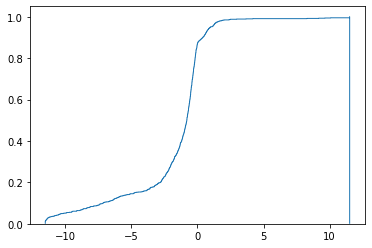

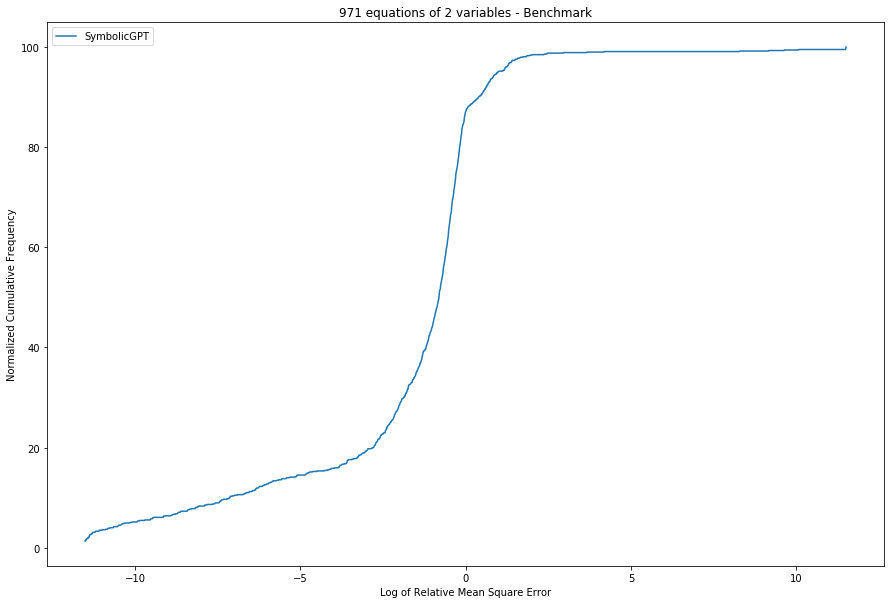

In [21]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict[fName]['SymbolicGPT'])
num_vars = pconf.numberofVars

models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key])==num_eqns)
lists_of_error_scores = [resultDict[fName][key] for key in models if len(resultDict[fName][key])==num_eqns]
linestyles = ["-","dashdot","dotted","--"]

eps = 0.00001
y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=2000, 
                   density=True,
                   log=False)
y = np.expand_dims(y,0)
plt.figure(figsize=(15, 10))

for idx, m in enumerate(models): 
    plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=m)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables - Benchmark".format(num_eqns, num_vars))
plt.xlabel("Log of Relative Mean Square Error")
plt.ylabel("Normalized Cumulative Frequency")

name = '{}.png'.format(fName.split('.txt')[0])
print(name)
plt.savefig(name)

In [22]:
# benchmarks
import csv
rng = np.random.RandomState(seed)
benchmarkPath = './benchmark/dsr-benchmark-data/'
dataPoints = glob.glob(benchmarkPath+'*.csv')
NGUYEN2Eq = {
           '1':'x1**3+x1**2+x1',
           '2':'x1**4+x1**3+x1**2+x1',
           '3':'x1**5+x1**4+x1**3+x1**2+x1',
           '4':'x1**6+x1**5+x1**4+x1**3+x1**2+x1',
           '5':'sin(x1**2)*cos(x1)-1',
           '6':'sin(x1)+sin(x1+x1**2)',
           '7':'log(x1+1)+log(x1**2+1)',
           '8':'sqrt(x1)',
           '9':'sin(x1)+sin(x2**2)',
           '10':'2*sin(x1)*cos(x2)',
           '11':'x1**x2',
           '12':'x1**4-x1**3+x2**2/2-x2',}
for dataPoint in dataPoints: 
    key = dataPoint.split('\\')[-1].split('Nguyen-')[-1].split('_')[0]
    if not key in NGUYEN2Eq.keys():
        continue
    target = NGUYEN2Eq[key]
    with open(dataPoint, newline='\n') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        pointsList = []
        pointsListTest = []
        for i, c in enumerate(reader):
            p = ([eval(x) for x in c[:-1]],eval(c[-1]))
            if i < numPoints:
                pointsList.append(p)
            else:
                pointsListTest.append(p)
                
        #pointsList = [([eval(x) for x in p[:-1]],eval(p[-1])) for i,p in enumerate(reader) if i < numPoints]
        #pointsListTest = [([eval(x) for x in p[:-1]],eval(p[-1])) for i,p in enumerate(reader) if i >= numPoints]
        
        # initialized the input variable with start token <
        inputs = torch.tensor([[train_dataset.stoi['<']]]).to(trainer.device)
        
#         trainRange = [-1.0,1.0]
#         testRange = [1.1,3.0]
#         decimals = 2
#         X = np.round(rng.uniform(low=trainRange[0], high=trainRange[1], size=(numPoints,numVars)), decimals).tolist() # generate random points uniformly
#         # calculate Y based on the equation
#         Y = []
#         for point in X:
#             tmpEq = target + '' # copy the string
#             for varId in range(numVars):
#                 tmpEq = tmpEq.replace('x{}'.format(varId+1),str(np.round(point[varId], decimals)))
#             try: 
#                 y = eval(tmpEq)

#                 if math.isnan(y) or math.isinf(y):
#                     saveEq = False

#                 if type(y) is np.complex128 or type(y) is np.complex:
#                     print('Type was complex! Why?: {}'.format(tmpEq))
#                     y = 0 #abs(err.real)
#                     saveEq = False
#             except ZeroDivisionError:
#                 print('Zero Division: {}'.format(tmpEq))
#                 y = 0
#                 saveEq = False
#             except OverflowError:
#                 print('Overflow Error: {}'.format(tmpEq))
#                 y = 0
#                 saveEq = False
#             except:
#                 saveEq = False
#                 raise Exception('Err to process this equation: {}, original:{}'.format(tmpEq, target)) 
#             Y.append(float(round(y, decimals)))
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(pointsList): # zip(X,Y)): #
            x = xy[0][:numVars] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=train_dataset.threshold[1], 
                                 neginf=train_dataset.threshold[0])
            p[p>train_dataset.threshold[1]] = train_dataset.threshold[1] # clip the upper bound
            p[p<train_dataset.threshold[0]] = train_dataset.threshold[0] # clip the lower bound
            points[:,idx] = p
            
        points = points.unsqueeze(0).to(trainer.device)
        print(points)
        outputsHat = sample(model, inputs, blockSize, points=points,
                      temperature=1.0, sample=True, 
                      top_k=40)[0]
        
        # filter out predicted
        predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])
        predicted = predicted.strip(train_dataset.paddingToken).split('>')
        predicted = predicted[0] if len(predicted[0])>=1 else predicted[1]
        predicted = predicted.strip('<').strip(">")
        
        # extract points from the input sequence
        pointsTest = torch.zeros(numVars+numYs, numPoints).numpy()
        for idx, xy in enumerate(pointsListTest):
            x = xy[0][:numVars] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=train_dataset.threshold[1], 
                                 neginf=train_dataset.threshold[0])
            p[p>train_dataset.threshold[1]] = train_dataset.threshold[1] # clip the upper bound
            p[p<train_dataset.threshold[0]] = train_dataset.threshold[0] # clip the lower bound
            pointsTest[:,idx] = p
        
        Ys = [] 
        Yhats = []
        for xs in pointsTest[:-1,:].T:
            try:
                eqTmp = target + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                YEval = eval(eqTmp)
                YEval = 0 if np.isnan(YEval) else YEval
                YEval = 100 if np.isinf(YEval) else YEval
            except:
                YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
            Ys.append(YEval)
            try:
                eqTmp = predicted + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                Yhat = eval(eqTmp)
                Yhat = 0 if np.isnan(Yhat) else Yhat
                Yhat = 1000 if np.isinf(Yhat) else Yhat
            except:
                Yhat = 1000
            Yhats.append(Yhat)
        err = relativeErr(Ys,Yhats)
        
        print('NGUYEN-{} --> Target:{}\nPredicted:{}\nErr:{}\n'.format(key, target, predicted, err))

tensor([[[0.0228, 0.5305, 0.2433, 0.9136, 0.3163, 0.4688, 0.3219, 0.0062,
          0.4745, 0.4161, 0.7983, 0.8957, 0.2967, 0.6242, 0.8412, 0.4783,
          0.3515, 0.7232, 0.6044, 0.3533],
         [0.7287, 0.9873, 0.8273, 0.3342, 0.0560, 0.8409, 0.4420, 0.9682,
          0.5592, 0.3936, 0.6882, 0.7294, 0.8362, 0.2283, 0.3930, 0.6404,
          0.0765, 0.2168, 0.1425, 0.9563],
         [0.0340, 0.5575, 0.3261, 1.0000, 0.6211, 0.6025, 0.5720, 0.0070,
          0.7746, 0.7465, 1.0000, 1.0000, 0.3919, 1.0000, 1.0000, 0.7382,
          0.6866, 1.0000, 1.0000, 0.3990]]], device='cuda:0')
NGUYEN-10 --> Target:2*sin(x1)*cos(x2)
Predicted:C*sin(C*x1**2)*cos(C*x1+C)+C
Err:917593.808649203

tensor([[[0.0097, 0.7543, 0.5713, 0.8812, 0.5033, 0.3011, 0.4271, 0.5076,
          0.6796, 0.7826, 0.5016, 0.9677, 0.9850, 0.6700, 0.3650, 0.8412,
          0.1038, 0.3585, 0.8322, 0.6665],
         [0.9755, 0.8874, 0.5786, 0.4655, 0.0450, 0.2389, 0.0597, 0.0821,
          0.0700, 0.5811, 0.2115, 0.6883, 0

NGUYEN-9 --> Target:sin(x1)+sin(x2**2)
Predicted:C*x1**4-C*x1**3+C*x2**2/2-C*x2+C
Err:929675.2454212181

